__VGG16 Structure__

![image](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

In [1]:
# GPU setting
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"

# modules setting

import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import datetime

In [2]:
def one_hot(data, classes, nb_classes = 2):
    one_hot = [0]*nb_classes
    one_hot[classes] = 1
    return np.vstack([one_hot for i in range(len(data))])

def random_minibatch(x, y, batch_size = 50):
    idx = np.random.choice(len(x), batch_size)
    return x[idx], y[idx]

def shuffle(x, y):
    idx = np.arange(len(x))
    np.random.shuffle(idx)
    if type(x) == type(y):
        return x[idx], y[idx] 
    else:
        return x[idx]
    
def history(save = False):
    fig = plt.figure(figsize = (15,20))
    plt.suptitle('Training History', y = 0.92, fontsize = 20)
    
    x_axis = range(1, len(accr_train)+1)
    
    plt.subplot(2, 1, 1)
    plt.plot(x_axis, accr_train, 'b-', label = 'Training Accuracy')
    plt.plot(x_axis, accr_valid, 'r-', label = 'Validation Accuracy')
    plt.xlabel('n_iter/n_cal (n_cal = {})'.format(n_cal), fontsize = 15)
    plt.ylabel('Accuracy', fontsize = 15)
    plt.legend(fontsize = 10)
    plt.subplot(2, 1, 2)
    plt.plot(x_axis, loss_train, 'b-', label = 'Training Loss')
    plt.plot(x_axis, loss_valid, 'r-', label = 'Validation Loss')
    plt.xlabel('n_iter/n_cal (n_cal = {})'.format(n_cal), fontsize = 15)
    plt.ylabel('Loss', fontsize = 15)
#     plt.yticks(np.arange(0, 0.25, step=0.025))
    plt.legend(fontsize = 12)
    plt.show()
    if save == True:
        fig.savefig(hist_path + filename)
        plt.close(fig)

In [3]:
class Contents:
    def table(self):
        print('==============================================================')
        print('[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss')
        print('==============================================================')
    def evl(self):
        evl = '[{0:*>4d}] || {1:*>.2f} %    || {2:*>.2f} %    || {3:.8f} || {4:.8f}'.format(n_iter, 
                                                                                      accr_train[-1]*100, accr_valid[-1]*100, 
                                                                                      loss_train[-1], loss_valid[-1])
        return evl
    def prt_evl(self):
        print(self.evl())
        print('--------------------------------------------------------------')
    def early_under(self):
        print(self.evl() + ' [Early stopping - Underffiting !!]\n')
    def early_over(self):
        print(self.evl() + ' [Early stopping - Overffiting !!]\n')
    def early(self):
        print(self.evl() + ' [Early stopping]\n')
    def done(self):  
        global training_name
        global contents
        global filename
        global title
        
        now = datetime.datetime.now()
        nowDatetime = now.strftime('%y%m%d%H%M')
        
        contents = (
        'Training Time : {} Min.\n'.format(train_time) +
        'Early Stopping : {}\n'.format(early_stopping) +
        'Iteration : {}\n'.format(n_iter)
        )
        print(contents)

        title = '[ResNet-50] Training History'

# Load Data

In [4]:
train_dir =  '/mnt/disk1/yunseob/courses/19-2_computer vision/data/STFT/ch/train'
npy_files = os.listdir(train_dir)
npy_files

['dball_7.npy',
 'dball_14.npy',
 'dball_21.npy',
 'dinner_7.npy',
 'dinner_14.npy',
 'dinner_21.npy',
 'douter_7.npy',
 'douter_14.npy',
 'douter_21.npy',
 'normal.npy']

In [5]:
normal = np.load(os.path.join(train_dir, str([i for i in npy_files if 'normal' in i][0])))
ball_7 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'ball_7' in i][0])))
ball_14 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'ball_14' in i][0])))
ball_21 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'ball_21' in i][0])))
inner_7 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'inner_7' in i][0])))
inner_14 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'inner_14' in i][0])))
inner_21 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'inner_21' in i][0])))
outer_7 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'outer_7' in i][0])))
outer_14 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'outer_14' in i][0])))
outer_21 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'outer_21' in i][0])))

normal_y = one_hot(normal, 0, nb_classes = 10)
ball_7_y = one_hot(ball_7, 1, nb_classes = 10)
ball_14_y = one_hot(ball_14, 2, nb_classes = 10)
ball_21_y = one_hot(ball_21, 3, nb_classes = 10)
inner_7_y = one_hot(inner_7, 4, nb_classes = 10)
inner_14_y = one_hot(inner_14, 5, nb_classes = 10)
inner_21_y = one_hot(inner_21, 6, nb_classes = 10)
outer_7_y = one_hot(outer_7, 7, nb_classes = 10)
outer_14_y = one_hot(outer_14, 8, nb_classes = 10)
outer_21_y = one_hot(outer_21, 9, nb_classes = 10)

print("normal:", normal.shape, normal_y.shape)
print("ball_7:", ball_7.shape, ball_7_y.shape)
print("ball_14:", ball_14.shape, ball_14_y.shape)
print("ball_21:", ball_21.shape, ball_21_y.shape)
print("inner_7:", inner_7.shape, inner_7_y.shape)
print("inner_14:", inner_14.shape, inner_14_y.shape)
print("inner_21:", inner_21.shape, inner_21_y.shape)
print("outer_7:", outer_7.shape, outer_7_y.shape)
print("outer_14:", outer_14.shape, outer_14_y.shape)
print("outer_21:", outer_21.shape, outer_21_y.shape)

normal: (600, 100, 100, 8) (600, 10)
ball_7: (600, 100, 100, 8) (600, 10)
ball_14: (600, 100, 100, 8) (600, 10)
ball_21: (600, 100, 100, 8) (600, 10)
inner_7: (600, 100, 100, 8) (600, 10)
inner_14: (600, 100, 100, 8) (600, 10)
inner_21: (600, 100, 100, 8) (600, 10)
outer_7: (600, 100, 100, 8) (600, 10)
outer_14: (600, 100, 100, 8) (600, 10)
outer_21: (600, 100, 100, 8) (600, 10)


# Data split

In [6]:
def train_valid_split(data, label, train_rate = 0.85):
    train_idx = np.sort(np.random.choice(len(data), round(len(data)*train_rate), replace = False))
    valid_idx = np.setxor1d(train_idx, np.arange(len(data)))
    return data[train_idx], label[train_idx], data[valid_idx], label[valid_idx]

In [7]:
normal_train_x, normal_train_y, normal_valid_x, normal_valid_y = train_valid_split(normal, normal_y)
print("normal:", normal_train_x.shape, normal_train_y.shape, normal_valid_x.shape, normal_valid_y.shape)

ball_7_train_x, ball_7_train_y, ball_7_valid_x, ball_7_valid_y = train_valid_split(ball_7, ball_7_y)
ball_14_train_x, ball_14_train_y, ball_14_valid_x, ball_14_valid_y = train_valid_split(ball_14, ball_14_y)
ball_21_train_x, ball_21_train_y, ball_21_valid_x, ball_21_valid_y = train_valid_split(ball_21, ball_21_y)
print("ball_7:", ball_7_train_x.shape, ball_7_train_y.shape, ball_7_valid_x.shape, ball_7_valid_y.shape)
print("ball_14:", ball_14_train_x.shape, ball_14_train_y.shape, ball_14_valid_x.shape, ball_14_valid_y.shape)
print("ball_21:", ball_21_train_x.shape, ball_21_train_y.shape, ball_21_valid_x.shape, ball_21_valid_y.shape)

inner_7_train_x, inner_7_train_y, inner_7_valid_x, inner_7_valid_y = train_valid_split(inner_7, inner_7_y)
inner_14_train_x, inner_14_train_y, inner_14_valid_x, inner_14_valid_y = train_valid_split(inner_14, inner_14_y)
inner_21_train_x, inner_21_train_y, inner_21_valid_x, inner_21_valid_y = train_valid_split(inner_21, inner_21_y)
print("inner_7:", inner_7_train_x.shape, inner_7_train_y.shape, inner_7_valid_x.shape, inner_7_valid_y.shape)
print("inner_14:", inner_14_train_x.shape, inner_14_train_y.shape, inner_14_valid_x.shape, inner_14_valid_y.shape)
print("inner_21:", inner_21_train_x.shape, inner_21_train_y.shape, inner_21_valid_x.shape, inner_21_valid_y.shape)

outer_7_train_x, outer_7_train_y, outer_7_valid_x, outer_7_valid_y = train_valid_split(outer_7, outer_7_y)
outer_14_train_x, outer_14_train_y, outer_14_valid_x, outer_14_valid_y = train_valid_split(outer_14, outer_14_y)
outer_21_train_x, outer_21_train_y, outer_21_valid_x, outer_21_valid_y = train_valid_split(outer_21, outer_21_y)
print("outer_7:", outer_7_train_x.shape, outer_7_train_y.shape, outer_7_valid_x.shape, outer_7_valid_y.shape)
print("outer_14:", outer_14_train_x.shape, outer_14_train_y.shape, outer_14_valid_x.shape, outer_14_valid_y.shape)
print("outer_21:", outer_21_train_x.shape, outer_21_train_y.shape, outer_21_valid_x.shape, outer_21_valid_y.shape)

normal: (510, 100, 100, 8) (510, 10) (90, 100, 100, 8) (90, 10)
ball_7: (510, 100, 100, 8) (510, 10) (90, 100, 100, 8) (90, 10)
ball_14: (510, 100, 100, 8) (510, 10) (90, 100, 100, 8) (90, 10)
ball_21: (510, 100, 100, 8) (510, 10) (90, 100, 100, 8) (90, 10)
inner_7: (510, 100, 100, 8) (510, 10) (90, 100, 100, 8) (90, 10)
inner_14: (510, 100, 100, 8) (510, 10) (90, 100, 100, 8) (90, 10)
inner_21: (510, 100, 100, 8) (510, 10) (90, 100, 100, 8) (90, 10)
outer_7: (510, 100, 100, 8) (510, 10) (90, 100, 100, 8) (90, 10)
outer_14: (510, 100, 100, 8) (510, 10) (90, 100, 100, 8) (90, 10)
outer_21: (510, 100, 100, 8) (510, 10) (90, 100, 100, 8) (90, 10)


In [8]:
train_X = np.vstack([normal_train_x, ball_7_train_x, ball_14_train_x, ball_21_train_x, 
                     inner_7_train_x, inner_14_train_x, inner_21_train_x,
                     outer_7_train_x, outer_14_train_x, outer_21_train_x, ])
train_Y = np.vstack([normal_train_y, ball_7_train_y, ball_14_train_y, ball_21_train_y, 
                     inner_7_train_y, inner_14_train_y, inner_21_train_y,
                     outer_7_train_y, outer_14_train_y, outer_21_train_y, ])
valid_X = np.vstack([normal_valid_x, ball_7_valid_x, ball_14_valid_x, ball_21_valid_x, 
                     inner_7_valid_x, inner_14_valid_x, inner_21_valid_x,
                     outer_7_valid_x, outer_14_valid_x, outer_21_valid_x, ])
valid_Y = np.vstack([normal_valid_y, ball_7_valid_y, ball_14_valid_y, ball_21_valid_y, 
                     inner_7_valid_y, inner_14_valid_y, inner_21_valid_y,
                     outer_7_valid_y, outer_14_valid_y, outer_21_valid_y, ])

print("Training set:", train_X.shape, train_Y.shape)
print("Validation set:", valid_X.shape, valid_Y.shape)

Training set: (5100, 100, 100, 8) (5100, 10)
Validation set: (900, 100, 100, 8) (900, 10)


# Model

In [9]:
input_h = 100
input_w = 100
input_ch = 8

ch_1 = 16
# 50 50 16

ch_2 = 32
# 25 25 32

ch_3 = 32
# 12 12 16

ch_4 = 64
# 12 12 32

ch_5 = 128
# 6 6 128
n_hidden = 100
n_output = 10

In [10]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch], name = 'img')
y = tf.placeholder(tf.float32, [None, n_output], name = 'label')
is_training = tf.placeholder(tf.bool, name = 'is_training')

class VGG16:
    def __init__(self, ch_1, ch_2, ch_3, ch_4, ch_5, n_hidden, n_output):
        self.ch_1 = ch_1
        self.ch_2 = ch_2
        self.ch_3 = ch_3
        self.ch_4 = ch_4
        self.ch_5 = ch_5
        self.n_hidden = n_hidden
        self.n_output = n_output
    def conv(self, x, channel, kernel_size = [3, 3], strides = (1, 1)):
        conv = tf.layers.conv2d(inputs = x, filters = channel, kernel_size = kernel_size, 
                                strides = strides, padding = "SAME", activation = tf.nn.relu)
        return conv
    
    def maxp(self, conv):
        maxp = tf.layers.max_pooling2d(inputs = conv, pool_size = [2, 2], strides = 2)
        return maxp

    def vgg_block(self, x, channel, n_rep):
        for _ in range(n_rep):
            x = self.conv(x, channel)
        x = self.maxp(x)
        return x
    
    def fc_layer_dropout(self, x, n_hidden = None):
        output = tf.layers.dense(inputs = x, units = n_hidden)
        output = tf.layers.dropout(output, rate = 0.3, training = is_training)
        return output

    def inf(self, x):
        """
        conv_layer: 13
        fc_layer: 3

        total: 16
        """
        stage_1 = self.vgg_block(x, self.ch_1,  2) 
        stage_2 = self.vgg_block(stage_1, self.ch_1, 2) 
        stage_3 = self.vgg_block(stage_2, self.ch_1, 3) 
        stage_4 = self.vgg_block(stage_3, self.ch_1, 3) 
        stage_5 = self.vgg_block(stage_4, self.ch_1, 3) 
        flatten = tf.layers.flatten(stage_5)
        fc_1 = self.fc_layer_dropout(flatten, self.n_hidden)
        fc_2 = self.fc_layer_dropout(fc_1, self.n_hidden)
        score = tf.layers.dense(inputs = fc_2, units = self.n_output)
        return score

model = VGG16(ch_1, ch_2, ch_3, ch_4, ch_5, n_hidden, n_output)
score = model.inf(x)
loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=score)
loss = tf.reduce_mean(loss)

W1215 04:52:59.862250 140268406847232 deprecation.py:323] From <ipython-input-10-46425bcfd775>:18: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W1215 04:52:59.869033 140268406847232 deprecation.py:506] From /home/yunseob/.local/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1215 04:53:00.236755 140268406847232 deprecation.py:323] From <ipython-input-10-46425bcfd775>:22: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W1215 04:53:00.545933 140268406847232 deprecati

# Training

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss


W1215 04:53:22.288508 140268406847232 deprecation.py:323] From /home/yunseob/.local/lib/python3.5/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[*100] || 31.25 %    || 29.69 %    || 1.62875271 || 1.63734806
--------------------------------------------------------------
[*200] || 87.50 %    || 87.50 %    || 0.59974313 || 0.47661090
--------------------------------------------------------------
[*300] || 96.88 %    || 100.00 %    || 0.19869193 || 0.20062289
--------------------------------------------------------------
[*400] || 100.00 %    || 100.00 %    || 0.01484794 || 0.01393725
--------------------------------------------------------------
[*500] || 100.00 %    || 98.44 %    || 0.00198489 || 0.03061003
--------------------------------------------------------------
[*600] || 100.00 %    || 100.00 %    || 0.00082470 || 0.00095063
--------------------------------------------------------------
[*700] || 100.00 %    || 100.00 %    || 0.01414389 || 0.00658088
--------------------------------------------------------------
[*800] || 100.00 %    || 100.00 %    || 0.00143838 || 0.01018853
---------------------------------------------

[6600] || 100.00 %    || 100.00 %    || 0.00000874 || 0.00001029
--------------------------------------------------------------
[6700] || 100.00 %    || 100.00 %    || 0.00000437 || 0.00000887
--------------------------------------------------------------
[6800] || 100.00 %    || 100.00 %    || 0.00001103 || 0.00001667
--------------------------------------------------------------
[6900] || 100.00 %    || 100.00 %    || 0.00001355 || 0.00001055
--------------------------------------------------------------
[7000] || 100.00 %    || 100.00 %    || 0.00002109 || 0.00000663
--------------------------------------------------------------
[7100] || 100.00 %    || 100.00 %    || 0.00000464 || 0.00001443
--------------------------------------------------------------
[7200] || 100.00 %    || 100.00 %    || 0.00000445 || 0.00000103
--------------------------------------------------------------
[7300] || 100.00 %    || 100.00 %    || 0.00000356 || 0.00000741
---------------------------------------

[13000] || 100.00 %    || 100.00 %    || 0.00000134 || 0.00000035
--------------------------------------------------------------
[13100] || 100.00 %    || 100.00 %    || 0.00004033 || 0.00002055
--------------------------------------------------------------
[13200] || 100.00 %    || 100.00 %    || 0.00000102 || 0.00000230
--------------------------------------------------------------
[13300] || 100.00 %    || 100.00 %    || 0.00000088 || 0.00000072
--------------------------------------------------------------
[13400] || 100.00 %    || 100.00 %    || 0.00000375 || 0.00000110
--------------------------------------------------------------
[13500] || 100.00 %    || 100.00 %    || 0.00000009 || 0.00000986
--------------------------------------------------------------
[13600] || 100.00 %    || 100.00 %    || 0.00006848 || 0.00005991
--------------------------------------------------------------
[13700] || 100.00 %    || 100.00 %    || 0.00000211 || 0.00000054
-------------------------------

[19400] || 100.00 %    || 100.00 %    || 0.00000025 || 0.00000082
--------------------------------------------------------------
[19500] || 100.00 %    || 100.00 %    || 0.00000014 || 0.00000043
--------------------------------------------------------------
[19600] || 100.00 %    || 100.00 %    || 0.00000022 || 0.00000007
--------------------------------------------------------------
[19700] || 100.00 %    || 100.00 %    || 0.00000023 || 0.00000041
--------------------------------------------------------------
[19800] || 100.00 %    || 100.00 %    || 0.00000026 || 0.00000008
--------------------------------------------------------------
[19900] || 100.00 %    || 100.00 %    || 0.00000005 || 0.00000027
--------------------------------------------------------------
[20000] || 100.00 %    || 100.00 %    || 0.00000015 || 0.00000011
--------------------------------------------------------------
Training Time : 12 Min.
Early Stopping : False
Iteration : 20000



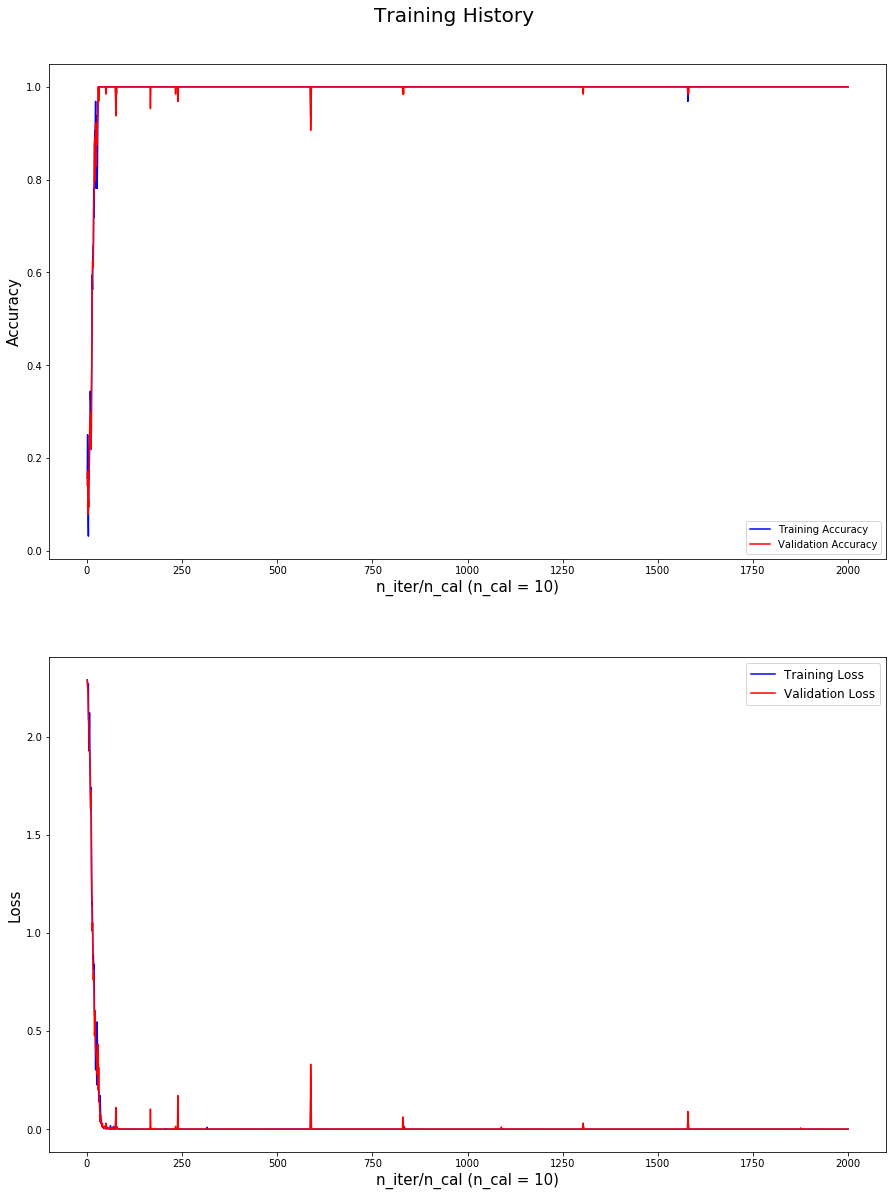

In [11]:
t_batch = 32
v_batch = 64
n_cal = 10
n_prt = 100

n_iter = 0

# LR = 1e-4 # 1e-4 ~ 5e-4 (xavier)

lr = 1e-4

# update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# with tf.control_dependencies(update_ops):
#     optm = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
optm = tf.train.AdamOptimizer(lr).minimize(loss)

con = Contents()

accr_valid = []
loss_valid = []
accr_train = []
loss_train = []

early_stopping = False

saver = tf.train.Saver()
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)
start_time = time.time() 

con.table()

while True:
    train_x, train_y = random_minibatch(train_X, train_Y, batch_size = t_batch)
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1})
    n_iter += 1
    if n_iter % n_cal == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        valid_x, valid_y = random_minibatch(valid_X, valid_Y, batch_size = v_batch)
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % n_prt == 0:
            con.prt_evl()
            
        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'stft_ch_vgg16_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/STFT/' + model_name)
        if n_iter == 20000:
            break
#         if n_iter > 1000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     con.early_under()
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     con.early_over()
#                     early_stopping = True
#                     break          

train_time = int((time.time() - start_time)/60)  
con.done()

np.save('/mnt/disk1/yunseob/courses/19-2_computer vision/history/VGG16_STFT_ch_accr', np.array(accr_train))
np.save('/mnt/disk1/yunseob/courses/19-2_computer vision/history/VGG16_STFT_ch_loss', np.array(loss_train))

history(save = False)   

# sess.close()